In [1]:
!pip install pyswarms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import cv2
import pywt
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pyswarms.single.global_best import GlobalBestPSO
# for dirname, _, filenames in os.walk('/kaggle/input/emotic'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Defining locations of images and csv files

image_loc = '/kaggle/input/emotic/img_arrs/'
dataframes_loc = '/kaggle/input/emotic/annots_arrs/'

In [4]:
def load_train_val_test():
    
    # Defining path for the training,validation and testing datasets
    
    train_path = r'/kaggle/input/emotic/annots_arrs/annot_arrs_train.csv'
    validation_path = r'/kaggle/input/emotic/annots_arrs/annot_arrs_val.csv'
    test_path = r'/kaggle/input/emotic/annots_arrs/annot_arrs_test.csv'
    
    # Importing the datasets
    
    dataset = pd.DataFrame()
    train_data = pd.read_csv(train_path)
    val_data = pd.read_csv(validation_path)
    test_data = pd.read_csv(test_path)
    
    #Concating into a single dataset
    
    dataset = pd.concat([dataset, train_data], axis=0)
    dataset = pd.concat([dataset, val_data], axis=0)
    dataset = pd.concat([dataset, test_data], axis=0)
    
    return dataset.iloc[0:10000,:]

In [5]:
dataset = load_train_val_test()

In [6]:
dataset.head()

,Filename,Width,Height,Age,Gender,Valence,Arousal,Dominance,Peace,Affection,...,Disquietment,Fear,Pain,Suffering,X_min,Y_min,X_max,Y_max,Arr_name,Crop_name
0,COCO_val2014_000000562243.jpg,640.0,640.0,Adult,Male,5.0,3.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,86.0,58.0,564.0,628.0,img_arr_0.npy,crop_arr_train_0.npy
1,COCO_train2014_000000288841.jpg,640.0,480.0,Adult,Male,6.0,4.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,485.0,149.0,605.0,473.0,img_arr_1.npy,crop_arr_train_1.npy
2,COCO_val2014_000000558171.jpg,640.0,480.0,Teenager,Male,7.0,8.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,305.0,92.0,461.0,465.0,img_arr_2.npy,crop_arr_train_2.npy
3,COCO_train2014_000000369575.jpg,480.0,640.0,Kid,Male,8.0,9.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,221.0,63.0,448.0,372.0,img_arr_3.npy,crop_arr_train_3.npy
4,COCO_train2014_000000213009.jpg,500.0,333.0,Adult,Male,7.0,9.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,44.0,143.0,150.0,288.0,img_arr_4.npy,crop_arr_train_4.npy


In [7]:
dataset.shape

(10000, 40)

In [8]:
dataset.columns

Index(['Filename', 'Width', 'Height', 'Age', 'Gender', 'Valence', 'Arousal',
       'Dominance', 'Peace', 'Affection', 'Esteem', 'Anticipation',
       'Engagement', 'Confidence', 'Happiness', 'Pleasure', 'Excitement',
       'Surprise', 'Sympathy', 'Doubt/Confusion', 'Disconnection', 'Fatigue',
       'Embarrassment', 'Yearning', 'Disapproval', 'Aversion', 'Annoyance',
       'Anger', 'Sensitivity', 'Sadness', 'Disquietment', 'Fear', 'Pain',
       'Suffering', 'X_min', 'Y_min', 'X_max', 'Y_max', 'Arr_name',
       'Crop_name'],
      dtype='object')

In [9]:
np.load('/kaggle/input/emotic/img_arrs/crop_arr_train_0.npy').shape

(224, 224, 3)

In [10]:
def getCoords(df):
    scene_x_min = pd.Series([0] * len(df.loc[:,"Width"])).astype('int')
    scene_x_max = pd.Series(df.loc[:,"Width"].astype('int'))
    scene_y_min = pd.Series([0] * len(df.loc[:,"Height"])).astype('int')
    scene_y_max = pd.Series(df.loc[:,"Height"].astype('int'))
    people_x_min = pd.Series(df.loc[:,"X_min"].astype('int'))
    people_x_max = pd.Series(df.loc[:,"X_max"].astype('int'))
    people_y_min = pd.Series(df.loc[:,"Y_min"].astype('int'))
    people_y_max = pd.Series(df.loc[:,"Y_max"].astype('int'))
    return [scene_x_min,scene_x_max,scene_y_min,scene_y_max,people_x_min,people_x_max,people_y_min,people_y_max]

In [11]:
emotion_mapping = {
    'Peace'             : 1,
    'Affection'         : 2,
    'Esteem'            : 3,
    'Anticipation'      : 4,
    'Engagement'        : 5,
    'Confidence'        : 6,
    'Happiness'         : 7,
    'Pleasure'          : 8,
    'Excitement'        : 9,
    'Surprise'          : 10,
    'Sympathy'          : 11,
    'Doubt/Confusion'   : 12,
    'Disconnection'     : 13,
    'Fatigue'           : 14,
    'Embarrassment'     : 15,
    'Yearning'          : 16,
    'Disapproval'       : 17,
    'Aversion'          : 18,
    'Annoyance'         : 19,
    'Anger'             : 20,
    'Sensitivity'       : 21,
    'Sadness'           : 22,
    'Disquietment'      : 23,
    'Fear'              : 24,
    'Pain'              : 25,
    'Suffering'         : 26
}

In [12]:
def get_Discrete_categories(sdf,tdf):
    categories = sdf.columns
    discrete_total=[]
    for ind,val in sdf.iterrows():
        discrete=[0] * 26
        for category in categories:
            if val[category] == 1.0:
                discrete[emotion_mapping[category]-1] = 1
        discrete_total.append(discrete)
    tdf.insert(loc=1,column='category',value=discrete_total)

In [13]:
def splitDataset(df):
    num_data = df[['Arr_name']]
    get_Discrete_categories(df.loc[:,['Peace', 'Affection', 'Esteem', 'Anticipation','Engagement', 'Confidence', 'Happiness', 'Pleasure', 'Excitement','Surprise', 'Sympathy', 'Doubt/Confusion', 'Disconnection', 'Fatigue','Embarrassment', 'Yearning', 'Disapproval', 'Aversion', 'Annoyance','Anger', 'Sensitivity', 'Sadness', 'Disquietment', 'Fear', 'Pain','Suffering']],num_data)
    files = df[['Filename','Arr_name','Crop_name']]
    coords = pd.DataFrame(getCoords(df)).transpose()
    coords.columns = ['scene_x_min','scene_x_max','scene_y_min','scene_y_max','people_x_min','people_x_max','people_y_min','people_y_max']
    return num_data,files,coords

In [14]:
img_data,file,coords = splitDataset(dataset)

In [15]:
img_data.head()

,Arr_name,category
0,img_arr_0.npy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ..."
1,img_arr_1.npy,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,img_arr_2.npy,"[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,img_arr_3.npy,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,img_arr_4.npy,"[0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [16]:
img_data.shape

(10000, 2)

In [17]:
def load_images(df):
    img_list = []
    for imga in df.iloc[:,0]:
        path=str(image_loc+imga)
        img = np.load(path)
        img_list.append(img)
    return img_list

In [18]:
def get_stationary_wavelet_entropy(img_gray):
    coeffs = pywt.swtn( data = img_gray, wavelet = 'haar', level = 4, start_level = 0, trim_approx = True, axes=[0,1] )
    entropy = []
    band_cat = ['ad','da','dd']
    for i in range(len(coeffs)):
        if i==0:
            for j in range(len(coeffs[i])):
                band = coeffs[i][j]
                band = band.flatten()
                band_entropy = -np.nansum(band**2 * np.log2(band**2,where =  band != 0))
                entropy.append(band_entropy)
        else :
            for j in band_cat:
                band = coeffs[i][j]
                band = band.flatten()
                band_entropy = -np.nansum(band**2 * np.log2(band**2,where =  band != 0))
                entropy.append(band_entropy)
    return entropy

In [19]:
def get_features(image_list):
    features = []
    for image in image_list:
        img_gray = get_grayscale(image)
        entropy = get_stationary_wavelet_entropy(img_gray)
        features.append(entropy)
    return features

In [20]:
def get_grayscale(img):
    return img[:,:,0]/224+img[:,:,1]/224+img[:,:,2]/224

In [21]:
image_list = load_images(img_data)

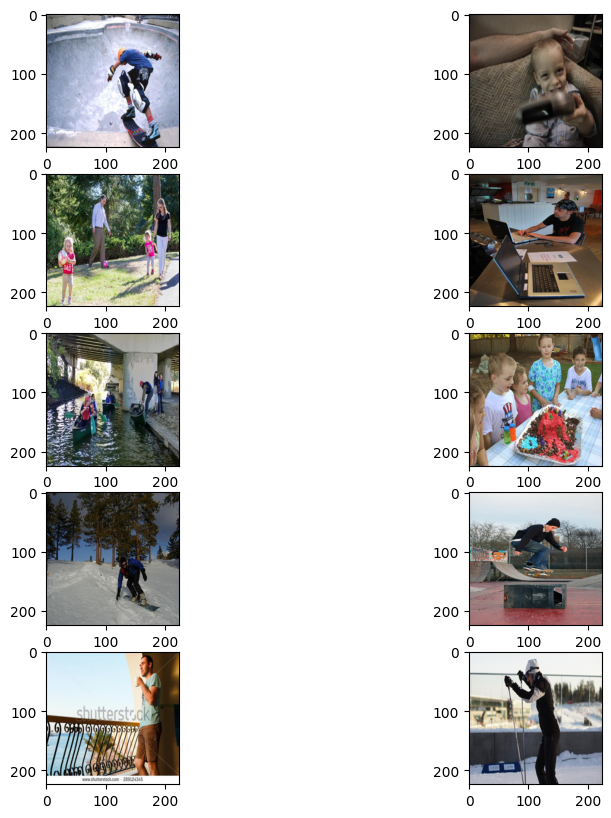

In [22]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.subplot(5,2,i+1)
    im = random.choice(image_list)
    plt.imshow(im)

In [23]:
X_features = get_features(image_list)

In [24]:
# for ind,vals in enumerate(zip(image_list[:10],X_features[:10])):
#     print(f'\n {ind} : Image \n')
#     print(vals[0])
#     print(f'\n {ind} : Feature \n')
#     print(vals[1])

In [25]:
Y=[]
for val in img_data.iloc[:,1].values:
    Y.append(val)

In [26]:
def get_predicted(pred):
    y_pred = []
    for prediction in pred:
        pr = []
        for x in prediction:
            if x>0.08:
                pr.append(1)
            else :
                pr.append(0)
        y_pred.append(pr)
    return y_pred

In [27]:
def multi_accuracy(Y_test,pred):
    y_pred = get_predicted(pred)
    correct = 0
    total = 0
    for predicted,actual in zip(y_pred,Y_test.numpy()):
        total += 1
        for ind in range(26):
            if predicted[ind]==1 and actual[ind] == 1:
                correct+=1
                break
    accuracy = (correct/total)
    return accuracy

In [28]:
X_train,X_test,Y_train,Y_test = train_test_split( X_features , Y , test_size = 0.2 , random_state = 0 )

In [29]:
num_features = len(X_features[0])
num_categories = len(Y[0])

print(num_features)
print(num_categories)

236
26


In [30]:
def create_model(learning_rate):
    model = Sequential(
    [
        tf.keras.layers.Dense(units = 64, activation='sigmoid', input_shape=(num_features,),kernel_regularizer=l2(0.001)),
        tf.keras.layers.Dense(num_categories, activation='sigmoid')
    ]
    )
    opt = Adam(learning_rate = learning_rate)
    model.compile( loss = 'binary_crossentropy' , optimizer= opt , metrics=[multi_accuracy],run_eagerly=True )
    return model

In [31]:
def fitness_function(params):
    model = create_model(params[1])
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    y_pred = []
    for prediction in pred:
        pr = []
        for x in prediction:
            if x>0.08:
                pr.append(1)
            else :
                pr.append(0)
        y_pred.append(pr)
    fitness = np.mean(y_pred == Y_test)
    return fitness

In [32]:
bounds = (np.array([0.0001, 0.001]), np.array([0.01, 0.1]))

In [33]:
callback = EarlyStopping(
    monitor = 'multi_accuracy' , 
    patience = 3 , 
    verbose = 0 , 
    mode = 'max' ,
    baseline = 0.85 ,
    restore_best_weights = True ,
    start_from_epoch = 5 )

In [34]:
model = create_model(0.01)
history = model.fit(X_train, Y_train, epochs=50, batch_size=64, callbacks = [callback])

Epoch 1/50
125/125 [==============================] - 105s 813ms/step - loss: 0.2494 - multi_accuracy: 0.8650
Epoch 2/50
125/125 [==============================] - 102s 815ms/step - loss: 0.2798 - multi_accuracy: 0.8528
Epoch 3/50
125/125 [==============================] - 102s 813ms/step - loss: 0.2879 - multi_accuracy: 0.8545
Epoch 4/50
125/125 [==============================] - 101s 811ms/step - loss: 0.2830 - multi_accuracy: 0.8576
Epoch 5/50
125/125 [==============================] - 101s 807ms/step - loss: 0.2745 - multi_accuracy: 0.8571
Epoch 6/50
125/125 [==============================] - 102s 813ms/step - loss: 0.2803 - multi_accuracy: 0.8554
Epoch 7/50
125/125 [==============================] - 102s 814ms/step - loss: 0.2849 - multi_accuracy: 0.8543
Epoch 8/50
125/125 [==============================] - 101s 811ms/step - loss: 0.2740 - multi_accuracy: 0.8562
Epoch 9/50
125/125 [==============================] - 101s 809ms/step - loss: 0.2674 - multi_accuracy: 0.8558
Epoch 10/5

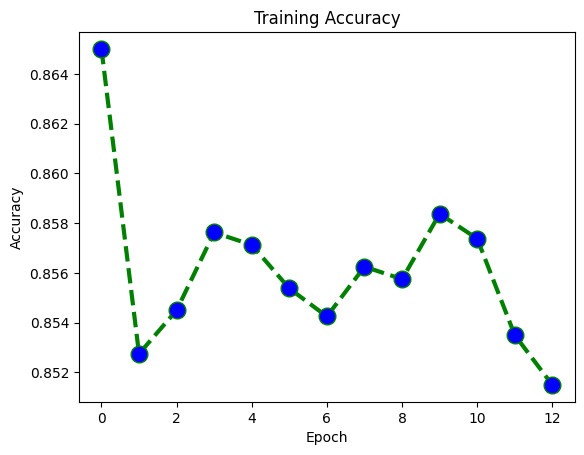

In [35]:
plt.plot(history.history['multi_accuracy'],color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

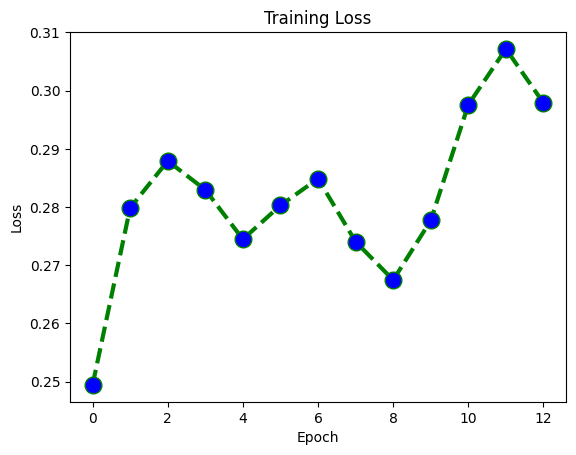

In [36]:
plt.plot(history.history['loss'],color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [37]:
# Run particle swarm optimization to optimize the model
# optimizer = GlobalBestPSO(n_particles=26, dimensions=2, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9})
# params = optimizer.optimize(fitness_function, iters=100)

In [38]:
# Train the MLPClassifier model using the optimized parameters
# model = create_model(params[1])
# model.fit(X_train, Y_train,epochs=100, batch_size=64)

In [39]:
pred = model.predict(X_test)

63/63 [==============================] - 0s 2ms/step


In [40]:
y_pred = get_predicted(pred)
def multi_accuracy_test(Y_test,y_pred):
    correct = 0
    total = 0
    for predicted,actual in zip(y_pred,Y_test):
        total += 1
        for ind in range(26):
            if predicted[ind]==1 and actual[ind] == 1:
                correct+=1
                break
    accuracy = (correct/total)
    return accuracy
accuracy = multi_accuracy_test(Y_test,y_pred)

In [41]:
print(f'The accuracy for the proposed model is {accuracy*100}%')

The accuracy for the proposed model is 85.1%


In [42]:
emotion_playlist = {
    'Peace'             : 'https://open.spotify.com/playlist/3WkLqvDQoIBVN3yhldrB6y?si=4724adf78526475d',
    'Affection'         : 'https://open.spotify.com/playlist/7HqauKS07jjRiWIL1tOv04?si=2d4a905f7e404439',
    'Esteem'            : 'https://open.spotify.com/playlist/3WrfkqANy0YcKNEycV6TUT?si=3a393923d97a4bbb',
    'Anticipation'      : 'https://open.spotify.com/playlist/0IusjjCCu02UMxOlrWLclP?si=a4dcc9d2cf2c4762',
    'Engagement'        : 'https://open.spotify.com/playlist/4LqhjH8JTTlua6EZvG78hU?si=998e4a8815c94a56',
    'Confidence'        : 'https://open.spotify.com/playlist/6fzpuuOf0b2iJNxn91vRnJ?si=d19073b30e0b43b3',
    'Happiness'         : 'https://open.spotify.com/playlist/7HqauKS07jjRiWIL1tOv04?si=5eb8821e73db46dc',
    'Pleasure'          : 'https://open.spotify.com/playlist/4mPr8pTNABKD3SfCknvhxy?si=ac971ac1e6a048a3',
    'Excitement'        : 'https://open.spotify.com/playlist/4uwGrrNc3Cyl8zz9jKBq35?si=fb86831c879e4b06',
    'Surprise'          : 'https://open.spotify.com/playlist/7hKb64k5os0UlhfubUFpM0?si=521acde84df440f1',
    'Sympathy'          : 'https://open.spotify.com/playlist/3IftKVQH2Hr5YynIEuAI7S?si=c14e5f4a4b054ed4',
    'Doubt/Confusion'   : 'https://open.spotify.com/playlist/4xDtaWZ3SuVxslRZi4mN6f?si=8747781d8a3849b5',
    'Disconnection'     : 'https://open.spotify.com/playlist/7mvdvn7LkiC7JyJOgUBZ4C?si=162f1eb58e054759',
    'Fatigue'           : 'https://open.spotify.com/playlist/7mvdvn7LkiC7JyJOgUBZ4C?si=2883976ba5a844d9',
    'Embarrassment'     : 'https://open.spotify.com/playlist/3TtFl1m1PD5iFu4zj8XgHd?si=f97bf25ffa3d4680',
    'Yearning'          : 'https://open.spotify.com/playlist/2BedOXLE2oA2KXdq75dDmT?si=b18badb3a6934988',
    'Disapproval'       : 'https://open.spotify.com/playlist/3k5T8gBYNuLp3RObImAxot?si=44c1b8f990214256',
    'Aversion'          : 'https://open.spotify.com/playlist/6bZFk5mLrGts5yFSXECR6v?si=187bcf09c80f4705',
    'Annoyance'         : 'https://open.spotify.com/playlist/6fzpuuOf0b2iJNxn91vRnJ?si=d8e70fcdd43144ae',
    'Anger'             : 'https://open.spotify.com/playlist/7kOcgryzQOw0GdOczDI8Mp?si=6a49d745819c459a',
    'Sensitivity'       : 'https://open.spotify.com/playlist/0zvvL2WqDaT8KRK1QtdPVg?si=d9abc583d4544c13',
    'Sadness'           : 'https://open.spotify.com/playlist/3yGRncfVkANbbBp000qP1m?si=1928b8c43ac04d88',
    'Disquietment'      : 'https://open.spotify.com/playlist/1CAbq0weZcna6wdAU1ZVwW?si=e83acc2a6a08471c',
    'Fear'              : 'https://open.spotify.com/playlist/3U732mnt7VRkE2IZDUDFDS?si=a3a96033bf5e4104',
    'Pain'              : 'https://open.spotify.com/playlist/53nirCP388i82OJKYCOaY2?si=ebe8c5fd3d5f465b',
    'Suffering'         : 'https://open.spotify.com/playlist/53nirCP388i82OJKYCOaY2?si=ebe8c5fd3d5f465b'
}

In [43]:
tester = y_pred[9]
indices = []
for y in range(26):
    if tester[y]==1:
        indices.append(y+1)
print(indices)
emotion_ind = random.choice(indices)

[4, 5, 6, 7, 8, 9]


In [44]:
emotion = None
for key,value in emotion_mapping.items():
    if value == emotion_ind:
        emotion = key
print(emotion)

Anticipation


In [45]:
playlist = emotion_playlist[emotion]
print(playlist)   

https://open.spotify.com/playlist/0IusjjCCu02UMxOlrWLclP?si=a4dcc9d2cf2c4762


In [46]:
real = '/kaggle/input/real-test/'